# Fit the complete data (With sWeights and without sWeights)
- Fit on $m(B^0_s)$ with:
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (sum of two Crystall ball PDF)
    - Background $B^0 \to D^{*-} D_s^+$ from the other fit of the simultaneous fit
    - Background with a misidentified pion: $B^0 \to D^{*-} K^+ \pi^+ \pi^-$ (sum of two crystall ball PDF)
    - Background of partially reconstructed decays $B^0 \to D^{*-} \pi^+ \pi^+ \pi^- h$ (gaussian)
    - Combinatorial background (exponential)
- Fit on $m(B^0_s)$ with $m(3\pi)$ around $m(D_s)$ and sWeights
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (gaussian)
    - Background of partially reconstructed decays (gaussian)
    - Combinatorial background (exponential)

## Import

In [ ]:
import zfit
import json
import numpy as np

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
import functions as fct
from fit import launch_fit, save_params, plot_hist_fit, plot_hist_fit_particle

## Load

In [ ]:
with open(f'{loc.JSON}/MC_cutallPIDK_params.json', 'r') as f:
    MC_param_results = json.load(f)

with open(f'{loc.JSON}/data_KPiPi_2_params.json', 'r') as f:
    data_KPiPi_params = json.load(f)

with open(f'{loc.JSON}/data_strip_p/all_data_strip_params.json', 'r') as f:
    mu2_p = json.load(f)['mu2']
    
with open(f'{loc.JSON}/all_data_strip_cutDeltaM_Ds_weighted_V8_params.json', 'r') as f:
    data_B0Ds_params = json.load(f)

weights =  fct.retrieve_pickle('all_data_strip_cutDeltaM_Ds_V8')
    
for var in 'muL', 'muR', 'sigmaL', 'sigmaR': # conversion GeV -> MeV
    data_KPiPi_params[var] = data_KPiPi_params[var]*1000
    data_KPiPi_params[f"{var}_err"] = data_KPiPi_params[f"{var}_err"]*1000

In [3]:
df = fct.load_data(years, magnets, type_data='data_strip', vars=['B0_M','tau_M'],
                            cut_DeltaM=True)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/data_strip/all_data_strip.root


In [4]:
size_tau_M = 50.
mean_tau_M = 1969.
low_tau_M = mean_tau_M - size_tau_M
high_tau_M = mean_tau_M + size_tau_M

df_Ds = df.query(f"abs(tau_M-{mean_tau_M})<={size_tau_M}")

In [5]:
name_data = 'all_data_strip_cutDeltaM_V8_sim'

## Distributions

### Init

#### Full `B0_M`

In [6]:
low = 5150.
high = 5550.

#### Weighted `B0_M` with `|tau_M-1969|<50`

In [7]:
name_data_B0Ds = 'all_data_strip_cutDeltaM_Ds_weighted_V8'
low_B0Ds = 5150.
high_B0Ds = 5360.

### Distributions

#### Full `B0_M`

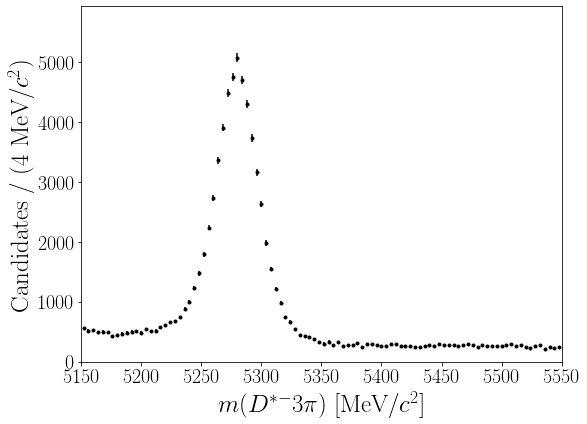

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_all_data_strip_cutDeltaM_V8_sim_B0_cut.pdf


In [8]:
fct.plot_hist_particle({name_data+'_B0_cut':df},'B0_M',
              low = low, high = high,
              n_bins = 100, mode_hist = False, colors='black')

#### Weighted `B0_M` with `|tau_M-1969|<50`

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/functions.py:579: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


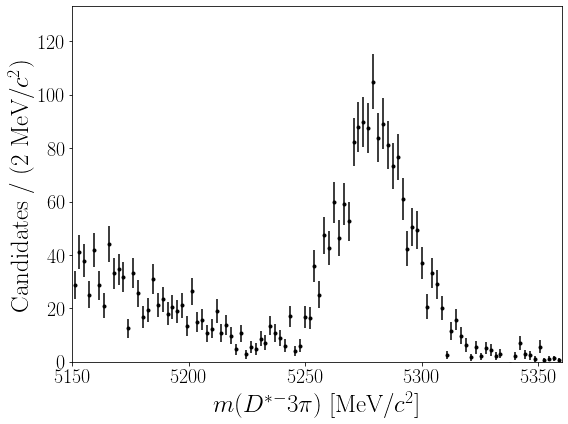

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_all_data_strip_cutDeltaM_Ds_weighted_V8.pdf


In [9]:
fct.plot_hist_particle({name_data_B0Ds:df_Ds},'B0_M',
              low = low_B0Ds, high = high_B0Ds,
              n_bins = 100, mode_hist = False, colors='black', weights=weights.sig)

## Fit on $m(B^0)$

### Intial values

#### Weighted `B0_M` with `|tau_M-1969|<50`

In [8]:
n_events_B0Ds = len(df_Ds.query(f'B0_M > {low_B0Ds} and B0_M < {high_B0Ds}'))

n_sig_k = 1600
n_bkg_k = 200
n_bkg2_k = 800

# n_sig_B0Ds         1564     +/-      44  -     44   +     45       False
# n_bkg_B0Ds        199.3     +/-      64  -     36   +1.6e+02       False
# n_bkg2_B0Ds       814.1     +/-      53  -1.5e+02   +     40       False
# mu_B0Ds            5280     +/-    0.59  -   0.44   +   0.44       False
# sigma_B0Ds        15.24     +/-    0.54  -   0.38   +   0.39       False
# lambda_B0Ds  -1.792e-06     +/- 7.7e-05  - 0.0059   +  0.011       False
# sigma2_B0Ds       76.31     +/-     3.9  -    4.6   +    3.3       False

initial_values_B0Ds = {
    # Signal
    'mu_B0Ds'       :{ 'value': 5279.                         , 'low': 5279.-4.       , 'high': 5279.+4.             , 'floating': True},
    'sigma_B0Ds'    :{ 'value': 15.                           , 'low': 15.-5.        , 'high': 15.+5.                , 'floating': True},
    'n_sig_B0Ds'    :{ 'value': n_sig_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Combinatorial background
    'lambda_B0Ds'   :{ 'value': -0.000001                     , 'low': -0.1           , 'high': -0.0000001           , 'floating': True},
    'n_bkg_B0Ds'    :{ 'value': n_bkg_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Partially reconstructed particles
    'mu2_B0Ds'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
    'sigma2_B0Ds'   :{ 'value': 80.                           , 'low': 50.            , 'high': 90.                  , 'floating': True},
    'n_bkg2_B0Ds'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
}


#### Full `B0_M`

In [9]:
n_events_B0_M = len(df.query(f'B0_M > {low} and B0_M < {high}'))

n_sig_k = 52000
n_bkg_k = 28000
n_bkg2_k = 500
n_bkgK_k = 3000


initial_values = {
    # Signal        
    'mu'       :{ 'value': 5279.                         , 'low': 5279.-5.       , 'high': 5279.+5.             , 'floating': True},
    'sigmaL'   :{ 'value': 17.9                          , 'low': 17.-15.        , 'high': 17.+15.              , 'floating': True},
    'sigmaR'   :{ 'value': 17.9                          , 'low': 17.-15.        , 'high': 17+15.               , 'floating': True},
    'alphaL'   :{ 'value': MC_param_results['alphaL_MC'] , 'low': 0.1            , 'high': 10.                  , 'floating': False},
    'alphaR'   :{ 'value': -MC_param_results['alphaR_MC'], 'low': -10.            , 'high': -0.1                , 'floating': False},
    'nL'       :{ 'value': MC_param_results['nL_MC']     , 'low': 0.1            , 'high': 200.                 , 'floating': False},
    'nR'       :{ 'value': MC_param_results['nR_MC']     , 'low': 1.             , 'high': 200.                 , 'floating': False},
    'frac'     :{ 'value': 0.5                           , 'low': 0.1              , 'high': 1.                  , 'floating': True},
    'n_sig'    :{ 'value': n_sig_k                       , 'low': n_sig_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
    # Combinatorial background        
    'lambda'   :{ 'value': -0.0008                       , 'low': -0.01          , 'high': -0.00001             , 'floating': True},
    'n_bkg'    :{ 'value': n_bkg_k                       , 'low': n_bkg_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
    # Partially reconstructed particles        
    'mu2'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
    'sigma2'   :{ 'value': 80.                           , 'low': 10.            , 'high': 5150.-mu2_p          , 'floating': True},
    'n_bkg2'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
    # Background decay D*Kpipi    
    'n_bkgK'   :{ 'value': n_bkgK_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
}



for var in 'muL', 'muR', 'sigmaL', 'sigmaR', 'nL', 'nR', 'alphaL', 'alphaR', 'nL', 'nR', 'fraction':
    initial_values[f'{var}_K'] = {'value': data_KPiPi_params[var], 'low': None, 'high': None, 'floating': False}


## Simultaneous fit

### Observables and variables

#### Weighted `B0_M` with `|tau_M-1969|<50`

In [10]:
obs_B0Ds = zfit.Space("x", limits=(low_B0Ds, high_B0Ds))

zparams_B0Ds = {}
for var in initial_values_B0Ds.keys():
    zparams_B0Ds[var] = zfit.Parameter(var,
                                      initial_values_B0Ds[var]['value'], 
                                      initial_values_B0Ds[var]['low'], 
                                      initial_values_B0Ds[var]['high'],
                                      floating = initial_values_B0Ds[var]['floating'])

In [11]:
name_params_B0Ds = {
    f'mu_B0Ds'      : '$\mu$',
    f'sigma_B0Ds'   : '$\\sigma_L$',
    f'sigma_B0Ds'   : '$\\sigma_R$',    
    f'alphaL_B0Ds'  : '$\\alpha_L$',
    f'alphaR_B0Ds'  : '$\\alpha_R$',
    f'nL_B0Ds'      : '$n_L$',
    f'nR_B0Ds'      : '$n_R$',
    f'n_bkg_B0Ds'   : '$n_{bkg,c}$',
    f'n_sig_B0Ds'   : '$n_{sig,D^*D_s}$',
    f'lambda_B0Ds'  : '$\\lambda$',
    f'mu2_B0Ds'     : '$\\mu_2$',
    f'sigma2_B0Ds'  : '$\\sigma_2$',
    f'n_bkg2_B0Ds'  : '$n_{bkg,D^*3 D_s h}$',
}

#### Full `B0_M`

In [12]:
obs = zfit.Space("x", limits=(low, high))

zparams = {}
for var in initial_values.keys():
    zparams[var] = zfit.Parameter(var,
                                  initial_values[var]['value'], 
                                  initial_values[var]['low'], 
                                  initial_values[var]['high'],
                                  floating = initial_values[var]['floating'])
    #print(zparams[var])

In [13]:
name_params = {
    f'mu'      : '$\mu_S$',
    f'sigmaL'  : '$\\sigma_L_S$',
    f'sigmaR'  : '$\\sigma_R_S$',    
    f'alphaL'  : '$\\alpha_L_S$',
    f'alphaR'  : '$\\alpha_R_S$',
    f'nL'      : '$n_L_S$',
    f'nR'      : '$n_R_S$',
    f'n_bkg'   : '$n_{B,c}$',
    f'n_sig'   : '$n_{S,D^*3\pi}$',
    f'lambda'  : '$\\lambda_{B,c}$',
    f'mu2'     : '$\\mu_{B,D^*3\pi h}$',
    f'sigma2'  : '$\\sigma_{B,D^*3\pi h}$',
    f'n_bkg2'  : '$n_{B,D^*3\pi h}$',
    f'n_bkgK'  : '$n_{B,D^*K\pi\pi}$',
    'frac'     : '$f_{S, \\frac{L}{R}}$'
}


### PDFs

#### Weighted `B0_M` with `|tau_M-1969|<50`

In [14]:
def crystall_ball_gaussian(mu, sigma, obs, alpha=None, n=None):
    if alpha is None or n is None:
        pdf = zfit.pdf.Gauss(mu, sigma, obs=obs)
    else:
        pdf = zfit.pdf.CrystalBall(mu, sigma, alpha, n, obs=obs)
    return pdf

def sum_crystalball(muL, muR, sigmaL, sigmaR, frac, obs, alphaL=None, alphaR=None, nL=None, nR=None):
    """ Return the sum of 2 crystall ball PDFs.
    If the alpha or n is None, the corresponding distribution is a gaussian.
    """
    pdfL = crystall_ball_gaussian(muL, sigmaL, obs,
                                         alphaL,nL)
    pdfR = crystall_ball_gaussian(muR, sigmaR, obs,
                                         alphaR, nR)
    
    model = zfit.pdf.SumPDF([pdfL, pdfR], fracs=frac)
    
    return model, pdfL, pdfR

In [15]:
gaussianS_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu_B0Ds'],zparams_B0Ds['sigma_B0Ds'],obs=obs_B0Ds)
exponential_B0Ds = zfit.pdf.Exponential(zparams_B0Ds['lambda_B0Ds'], obs=obs_B0Ds)
gaussian_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu2_B0Ds'],zparams_B0Ds['sigma2_B0Ds'],obs=obs_B0Ds)


gaussianS_B0Ds_ext = gaussianS_B0Ds.create_extended(zparams_B0Ds['n_sig_B0Ds'])
exponential_B0Ds_ext = exponential_B0Ds.create_extended(zparams_B0Ds['n_bkg_B0Ds'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams_B0Ds['n_bkg2_B0Ds'])

model_B0Ds = zfit.pdf.SumPDF([gaussianS_B0Ds_ext, exponential_B0Ds_ext, gaussian_B0Ds_ext])
data_B0Ds = zfit.Data.from_pandas(df_Ds['B0_M'], obs=obs_B0Ds, weights=weights.sig)

#### Full `B0_M`

In [16]:
model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                          zparams['sigmaL'], zparams['sigmaR'],
                                                          zparams['frac'], obs,                                                          
                                                          zparams['alphaL'], zparams['alphaR'], 
                                                          zparams['nL'], zparams['nR']
                                                         )


gaussian_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu_B0Ds'],zparams_B0Ds['sigma_B0Ds'],obs=obs)

model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_K'], zparams['muR_K'], 
                                                          zparams['sigmaL_K'], zparams['sigmaR_K'],
                                                          zparams['fraction_K'], obs,
                                                          zparams['alphaL_K'], zparams['alphaR_K'], 
                                                          zparams['nL_K'], zparams['nR_K'])

exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)
gaussian = zfit.pdf.Gauss(zparams['mu2'],zparams['sigma2'],obs=obs)



# sum of the two PDFs
model_S_ext = model_S.create_extended(zparams['n_sig'])

#doubleCB_Ds_ext = doubleCB_Ds.create_extended(zparams['n_sigb_B0Ds'])

exp_ext = exponential.create_extended(zparams['n_bkg'])
gaussian_ext = gaussian.create_extended(zparams['n_bkg2'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams_B0Ds['n_sig_B0Ds'])
model_K_ext = model_K.create_extended(zparams['n_bkgK'])

model = zfit.pdf.SumPDF([model_S_ext, gaussian_B0Ds_ext, gaussian_ext, model_K_ext, exp_ext]) # gauss is folded by frac
weights_one = np.ones(len(df['B0_M']))
data = zfit.Data.from_pandas(df['B0_M'], obs=obs, weights=weights_one)

### Fitting

In [17]:
#result_B0Ds, params_B0Ds = launch_fit( model_B0Ds, data_B0Ds, extended=True)

In [18]:
#result, params = launch_fit(model, data, extended=True)

In [19]:
# import timeit
# start = timeit.default_timer()
result, params = launch_fit([model_B0Ds, model], [data_B0Ds, data], extended=True)
# stop = timeit.default_timer()
# print('Time to do the fit: ', stop - start) 

------------------------------------------------------------------
| FCN = -4.307e+05              |    Ncalls=1856 (1856 total)    |
| EDM = 0.000481 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/zfit/minimizers/fitresult.py:46: ExperimentalFeatureWarning: The computation of the covariance matrix with weights is still experimental.
  ExperimentalFeatureWarning)
/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/zfit/minimizers/fitresult.py:238: RuntimeWarning: Exception occurred, parameter values are not reset and in an arbitrary, last used state. If this happens during normal operation, make sure you reset the values.
  RuntimeWarning)


AssertionError: 

#### Weighted `B0_M` with `|tau_M-1969|<50`

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/fit.py:548: UserWarning: The function <function Space.limits at 0x7f0a20f945f0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5360.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  low = float(obs.limits[0])
/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/functions.py:579: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)
/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/fit.py:37: UserWarning: The function <function Space.area at 0x7f0a20f9a9e0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5360.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is i

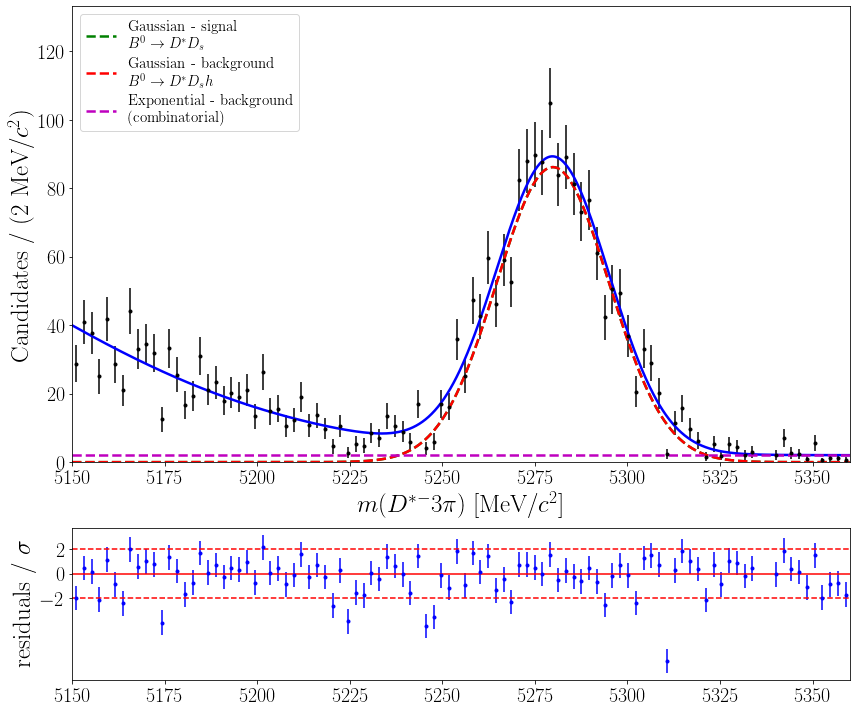

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_data_strip_cutDeltaM_V8_sim/B0_M_all_data_strip_cutDeltaM_Ds_weighted_V8_fit.pdf


In [19]:
plot_hist_fit_particle(df_Ds,'B0_M', models = [model_B0Ds, gaussianS_B0Ds_ext, gaussian_B0Ds_ext, exponential_B0Ds_ext],
                       name_models = [None, '\n $B^0\\to D^*D_s$','\n $B^0\\to D^*D_s h$',
                                      '\n (combinatorial)'],
                       obs=obs_B0Ds, n_bins = 100,mode_hist = False,
                       name_data = name_data_B0Ds, name_folder=name_data,
                       colors=['b','g','r','m','cyan','y'], weights=weights.sig,
                       #params=params_B0Ds,name_params=name_params_B0Ds,
#                       colWidths=[0.07,0.01,0.05,0.06],
                       fontsize_leg=15)

#### Full `B0_M`

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


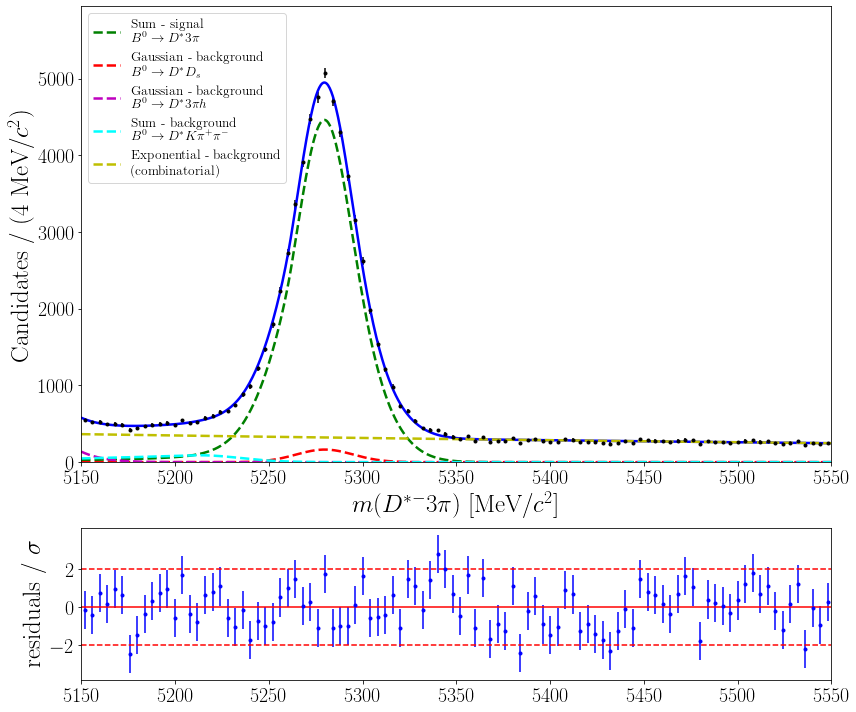

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_data_strip_cutDeltaM_V8_sim/B0_M_all_data_strip_cutDeltaM_V8_sim_fit.pdf


In [20]:
plot_hist_fit_particle(df,'B0_M', models = [model,model_S_ext, gaussian_B0Ds_ext, gaussian_ext, model_K_ext,exp_ext],
                       name_models = [None, '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$','\n $B^0\\to D^*3\pi h$',
                                      '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data, name_folder=name_data,
                       colors=['b','g','r','m','cyan','y'],
                       #params=params,name_params=name_params, 
                       fontsize_leg=13.5,
#                       colWidths=[0.06,0.01,0.05,0.06]
                      )

In [23]:
#save_params(params,name_data,True)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/all_data_strip_cutDeltaM_V8_fixedTails_params.json
